In [1]:
import pickle
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
import random
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from environment import get_carenvvec
from common import min_gps, max_gps, real_distance, block_number, cuda
blocks = block_number[0] * block_number[1]
delta_gps = max_gps - min_gps

consts

In [2]:
CANCELPROB_BATCH_SIZE = 4096
CANCELPROB_TESTSIZE = 0.05
CANCELPROB_EPOCH = 10
CANCELPROB_MIN_EPOCH = 10
CANCELPROB_LR = 0.01
CANCELPROB_EVAL_ITERATION = 1000
CANCELPROB_MODEL = 'cancelProb/best.pt'

In [3]:
GRID_BATCH_SIZE = 256
GRID_TESTSIZE = 0.1
GRID_EPOCH = 100
GRID_MIN_EPOCH = 100
GRID_LR = 0.001
GRID_EVAL_ITERATION = 1000
GRID_MODEL = 'grid/best.pt'

data read & process

In [4]:
pkl_folder = 'data/pkl/'
model_folder = 'data/model/'

cancel_prob_all_data = pickle.load(open(pkl_folder + 'cancel_prob_train.pkl', 'rb'))
grid_order_reward_all_data = pickle.load(open(pkl_folder + 'grid_order_reward.pkl', 'rb'))
hex_grid_data = pickle.load(open(pkl_folder + 'hex_grid.pkl', 'rb'))
print(cancel_prob_all_data.keys(), grid_order_reward_all_data.keys(), hex_grid_data.keys())

dict_keys(['hour', 'pos', 'ETA', 'prob', 'reward']) dict_keys(['order', 'reward']) dict_keys(['center', 'ID', 'vertex'])


In [5]:
def make_standard_normal(indict, keys):
    stdmean = {}
    for i in keys:
        j = [indict[i].mean(), indict[i].std()]
        indict[i] = (indict[i].astype('float') - j[0]) / j[1]
        stdmean[i] = j
    return stdmean
cancel_prob_stdmean = make_standard_normal(cancel_prob_all_data, ['ETA', 'reward'])

#grid
grid_order_reward_all_data['order'] = np.log(grid_order_reward_all_data['order'] + 1)
grid_reward = grid_order_reward_all_data['reward']
grid_order_reward_all_data['reward'] = grid_reward[grid_reward != 0]
grid_stdmean = make_standard_normal(grid_order_reward_all_data, ['reward', 'order'])
grid_reward[grid_reward != 0] = grid_order_reward_all_data['reward']
grid_order_reward_all_data['reward'] = grid_reward

#hex grid
hex_grid_stdmean = [hex_grid_data['center'].mean(axis=0), hex_grid_data['center'].std(axis=0)]
hex_grid_data['center'] = (hex_grid_data['center'] - hex_grid_stdmean[0]) / hex_grid_stdmean[1]
cancel_prob_all_data['pos'] = (cancel_prob_all_data['pos'] - min_gps) / delta_gps - 0.5
print(cancel_prob_stdmean, grid_stdmean, hex_grid_stdmean)

{'ETA': [1327.0779045105526, 847.6405218280669], 'reward': [4.182467829036552, 2.826104770240745]} {'order': [1.3818544802263453, 2.0466071372530115], 'reward': [0.003739948797879627, 0.000964668315987685]} [array([103.99934794,  30.64954967]), array([0.53464349, 0.32957612])]


In [6]:
def datasplit(data_dict, test_line):
    k = list(data_dict.keys())
    print(k)
    alldata = []
    for i in k:
        alldata.append(data_dict[i])
    alldata = list(zip(*alldata))
    print(len(alldata))
    line = int((1 - test_line) * len(alldata))
    random.shuffle(alldata)
    traindata = list(zip(*alldata[:line]))
    testdata = list(zip(*alldata[line:]))
    trainres = {}
    testres = {}
    for i in range(len(k)):
        trainres[k[i]] = traindata[i]
        testres[k[i]] = testdata[i]
    return trainres, testres

In [7]:
#for i in grid_order_reward_all_data.keys():
#    grid_order_reward_all_data[i] = grid_order_reward_all_data[i][:-1,:,:]
print(grid_order_reward_all_data['reward'].shape)
shape = grid_order_reward_all_data['reward'].shape
temparr = np.zeros(shape, dtype='int')
temparr[:] = np.arange(shape[1])
grid_order_reward_all_data['hour'] = temparr
temparr = np.zeros(shape, dtype='int')
temparr = np.transpose(temparr, (1, 0))
temparr[:] = np.arange(shape[0])
temparr = np.transpose(temparr, (1, 0))
grid_order_reward_all_data['pos'] = temparr

# TODO: remove 0-3h
# TODO: remove zeros

for k in grid_order_reward_all_data.keys():
    grid_order_reward_all_data[k] = grid_order_reward_all_data[k].reshape(-1)

(2500, 24)


In [8]:
class CancelProbDataset(Dataset):
    def __init__(self, cancel_prob_dict):
        super(CancelProbDataset, self).__init__()
        for key in cancel_prob_dict.keys():
            exec('self.' + key + " = cancel_prob_dict['" + key + "']")
    def __len__(self):
        return len(self.pos)
    def __getitem__(self, x):
        # startPos, endPos, hour, reward, ETA, prob
        return (*self.pos[x], self.hour[x], self.reward[x], self.ETA[x], self.prob[x])

cancel_prob_train_data, cancel_prob_test_data = datasplit(cancel_prob_all_data, CANCELPROB_TESTSIZE)
    
cancelProbTrainDataset = CancelProbDataset(cancel_prob_train_data)
cancelProbTrainDataLoader = DataLoader(cancelProbTrainDataset, CANCELPROB_BATCH_SIZE, True)
print(len(cancelProbTrainDataLoader))
cancelProbTestDataset = CancelProbDataset(cancel_prob_test_data)
cancelProbTestDataLoader = DataLoader(cancelProbTestDataset, CANCELPROB_BATCH_SIZE, True)
print(len(cancelProbTestDataLoader))

['hour', 'prob', 'ETA', 'reward', 'pos']
6104884
1416
75


In [9]:
class GridDataset(Dataset):
    def __init__(self, grid_dict, center):
        super(GridDataset, self).__init__()
        for key in grid_dict.keys():
            exec('self.' + key + " = grid_dict['" + key + "']")
        self.center = center
    def __len__(self):
        return len(self.reward)
    def __getitem__(self, x):
        posx = self.pos[x] / block_number[1] + 0.5
        posy = self.pos[x] % block_number[1] + 0.5
        pos = [posx, posy] / block_number - 0.5
        return (pos, self.hour[x], self.order[x], self.reward[x])
grid_order_reward_train_data, grid_order_reward_test_data = datasplit(grid_order_reward_all_data, GRID_TESTSIZE)
    
gridTrainDataset = GridDataset(grid_order_reward_train_data, hex_grid_data['center'])
gridTrainDataLoader = DataLoader(gridTrainDataset, GRID_BATCH_SIZE, True)
print(len(gridTrainDataLoader))
gridTestDataset = GridDataset(grid_order_reward_test_data, hex_grid_data['center'])
gridTestDataLoader = DataLoader(gridTestDataset, GRID_BATCH_SIZE, True)
print(len(gridTestDataLoader))

['order', 'hour', 'reward', 'pos']
60000
211
24


model

In [10]:
class CancelProbModel(nn.Module):
    def __init__(self, hourfeat = 8):
        super(CancelProbModel, self).__init__()
        self.houremb = nn.Embedding(24, hourfeat)
        
        self.fc = nn.Sequential(
            nn.Linear(hourfeat + 6, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
    # startPos, endPos, hour, reward, ETA, prob
    def forward(self, startPos, endPos, hour, reward, ETA):
        startPos = startPos.float()
        endPos = endPos.float()
        hour = self.houremb(hour)
        reward = reward.unsqueeze(1)
        ETA = ETA.unsqueeze(1)
        #print(startGID.shape, endGID.shape, hour.shape, week.shape)
        x = torch.cat((startPos, endPos, hour, reward, ETA), dim = 1)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x

In [27]:
class GridModel(nn.Module):
    def __init__(self, hourfeat = 8):
        super(GridModel, self).__init__()
        self.houremb = nn.Embedding(24, hourfeat)
        
        self.order = nn.Sequential(
            nn.Linear(hourfeat + 2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.reward = nn.Sequential(
            nn.Linear(hourfeat + 2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, GPS, hour):
        GPS = GPS.float()
        hour = self.houremb(hour)
        #print(GID.shape, hour.shape, week.shape)
        x = torch.cat((GPS, hour), dim = 1)
        #print(x.shape)
        return self.order(x).squeeze(), self.reward(x).squeeze()

In [12]:
def drawTSNE(datain, label, model):
    data = model(torch.tensor(datain).cuda()).detach().cpu().numpy()
    #tsne = TSNE(n_components=data.shape[1], learning_rate=100)
    #data = np.array([[1,1,1],[1,1,1],[0,0,0],[0,0,0],[0,0,0],[1,1,1],[0,0,0]])
    print(data[:100])
    tsne = TSNE(method ='barnes_hut')
    tsne = PCA()
    data = tsne.fit_transform(data)
    plt.scatter(data[:,0], data[:,1], 10, label)
    plt.colorbar()
    plt.show()

In [64]:
cancelProbModel = cuda(CancelProbModel())
cancelProbOpt = torch.optim.Adam(cancelProbModel.parameters(), CANCELPROB_LR)
cancelProbLoss = nn.MSELoss()
best_result = {
    'model': None,
    'opt': None,
    'loss': 1e100,
    'epoch': 0,
    'iteration': 0
}
if CANCELPROB_MODEL != '':
    if os.path.exists(model_folder + CANCELPROB_MODEL):
        best_result = torch.load(model_folder + CANCELPROB_MODEL)
        cancelProbModel.load_state_dict(best_result['model'])
        cancelProbOpt.load_state_dict(best_result['opt'])
    else:
        print('model file not find:', model_folder + CANCELPROB_MODEL)
iteration = best_result['iteration']
end_epoch = CANCELPROB_EPOCH
if best_result['epoch'] + CANCELPROB_MIN_EPOCH > end_epoch:
    end_epoch = best_result['epoch'] + CANCELPROB_MIN_EPOCH
for epoch in range(best_result['epoch'], end_epoch):
    for num, data in enumerate(cancelProbTrainDataLoader):
        data = list(map(cuda, data))
        cancelProbModel.train()
        cancelProbOpt.zero_grad()
        output = data[-1].float()
        #output[:] = (data[3] > 2).float().unsqueeze(1)
        data = data[:-1]
        res = cancelProbModel(*data)
        #if output.sum() > 0: print(res, output)
        l = cancelProbLoss(res, output)
        l.backward()
        cancelProbOpt.step()
        if iteration % CANCELPROB_EVAL_ITERATION == 0:
            # test
            test_res = []
            for data in cancelProbTestDataLoader:
                data = list(map(cuda, data))
                cancelProbModel.eval()
                output = data[-1].float()
                data = data[:-1]
                res = cancelProbModel(*data)
                l = cancelProbLoss(res, output)
                test_res.append(l)
            test_res = torch.tensor(test_res)
            test_res = test_res.mean().item()
            print('epoch: %d, iteration: %d, train loss: %f, eval loss: %f' % (epoch, iteration, l, test_res))
            torch.save(best_result, model_folder + 'cancelProb/%04d.pt' % epoch)
            with open(model_folder + 'cancelProb/log.txt', 'a') as f:
                isbest = '\tbest' if test_res < best_result['loss'] else ''
                f.write('%04d %08d %f%s\n' % (epoch, iteration, test_res, isbest))
            if test_res < best_result['loss']:
                best_result = {
                    'model': cancelProbModel.state_dict(),
                    'opt': cancelProbOpt.state_dict(),
                    'loss': test_res,
                    'epoch': epoch,
                    'iteration': iteration
                }
                torch.save(best_result, model_folder + 'cancelProb/best.pt')
        iteration += 1

epoch: 2, iteration: 3000, train loss: 0.011650, eval loss: 0.010298
epoch: 2, iteration: 4000, train loss: 0.011212, eval loss: 0.010205
epoch: 3, iteration: 5000, train loss: 0.010477, eval loss: 0.010126
epoch: 4, iteration: 6000, train loss: 0.008616, eval loss: 0.009993
epoch: 4, iteration: 7000, train loss: 0.009837, eval loss: 0.009940
epoch: 5, iteration: 8000, train loss: 0.009529, eval loss: 0.009925
epoch: 6, iteration: 9000, train loss: 0.011414, eval loss: 0.009875
epoch: 6, iteration: 10000, train loss: 0.008639, eval loss: 0.009845
epoch: 7, iteration: 11000, train loss: 0.010770, eval loss: 0.009824
epoch: 8, iteration: 12000, train loss: 0.010218, eval loss: 0.009783
epoch: 9, iteration: 13000, train loss: 0.009549, eval loss: 0.009846
epoch: 9, iteration: 14000, train loss: 0.010622, eval loss: 0.009788
epoch: 10, iteration: 15000, train loss: 0.009749, eval loss: 0.009762
epoch: 11, iteration: 16000, train loss: 0.010086, eval loss: 0.009800
epoch: 11, iteration: 170

In [43]:
gridModel = cuda(GridModel())
gridOpt = torch.optim.Adam(gridModel.parameters(), GRID_LR)
gridLoss1 = nn.MSELoss()
gridLoss2 = nn.MSELoss()
best_result = {
    'model': None,
    'opt': None,
    'loss': 1e100,
    'epoch': 0,
    'iteration': 0
}
if GRID_MODEL != '':
    if os.path.exists(model_folder + GRID_MODEL):
        best_result = torch.load(model_folder + GRID_MODEL)
        gridModel.load_state_dict(best_result['model'])
        gridOpt.load_state_dict(best_result['opt'])
    else:
        print('model file not find:', model_folder + GRID_MODEL)
iteration = best_result['iteration']
end_epoch = GRID_EPOCH
if best_result['epoch'] + GRID_MIN_EPOCH > end_epoch:
    end_epoch = best_result['epoch'] + GRID_MIN_EPOCH
for epoch in range(best_result['epoch'], end_epoch):
    for data in gridTrainDataLoader:
        data = list(map(cuda, data))
        gridModel.train()
        gridOpt.zero_grad()
        output = data[-2:]
        data = data[:-2]
        res = gridModel(*data)
        l1 = gridLoss1(res[0], output[0])
        l2 = gridLoss2(res[1][output[1] != 0], output[1][output[1] != 0])
        #l2 = 0
        (l1 / 3 + l2).backward()
        gridOpt.step()
        if iteration % 1000 == 0:
            #print('iteration: %d, loss: %f %f' % (iteration, l1, l2))
            #if (random.randint(1,5)==1): break
            # test
            test_res = []
            for data in gridTestDataLoader:
                #print(data)
                data = list(map(cuda, data))
                gridModel.eval()
                output = [data[-2].float(), data[-1].float()]
                data = data[:-2]
                res = gridModel(*data)
                #print(res,output)
                if res[0].shape != output[0].shape or res[1].shape != output[1].shape:
                    print(res, output)
                l1 = gridLoss1(res[0], output[0])
                l2 = gridLoss2(res[1][output[1] != 0], output[1][output[1] != 0])
                #l2 = l1
                test_res.append([l1, l2])
            test_res = torch.tensor(test_res)
            test_res = test_res.mean(dim = 0)
            print('epoch: %d, iteration: %d, loss: %f %f, eval loss: %f %f' % (epoch, iteration, l1, l2, test_res[0].item(), test_res[1].item()))
            test_res = test_res.mean().item()
            torch.save(best_result, model_folder + 'grid/%04d.pt' % epoch)
            with open(model_folder + 'grid/log.txt', 'a') as f:
                isbest = '\tbest' if test_res < best_result['loss'] else ''
                f.write('%04d %08d %f%s\n' % (epoch, iteration, test_res, isbest))
            if test_res < best_result['loss']:
                best_result = {
                    'model': gridModel.state_dict(),
                    'opt': gridOpt.state_dict(),
                    'loss': test_res,
                    'epoch': epoch,
                    'iteration': iteration
                }
                torch.save(best_result, model_folder + 'grid/best.pt')
        iteration += 1

epoch: 154, iteration: 33000, loss: 0.237230 0.052777, eval loss: 0.196284 0.069579
epoch: 158, iteration: 34000, loss: 0.219861 0.052195, eval loss: 0.198533 0.074989
epoch: 163, iteration: 35000, loss: 0.185880 0.048030, eval loss: 0.201433 0.073826
epoch: 168, iteration: 36000, loss: 0.285468 0.046721, eval loss: 0.216962 0.075192
epoch: 172, iteration: 37000, loss: 0.198428 0.098834, eval loss: 0.201587 0.078768
epoch: 177, iteration: 38000, loss: 0.177941 0.060055, eval loss: 0.201909 0.073174
epoch: 182, iteration: 39000, loss: 0.199790 0.051764, eval loss: 0.204982 0.076440
epoch: 187, iteration: 40000, loss: 0.212650 0.055019, eval loss: 0.202161 0.073627
epoch: 191, iteration: 41000, loss: 0.195757 0.055273, eval loss: 0.199553 0.073077
epoch: 196, iteration: 42000, loss: 0.185633 0.024238, eval loss: 0.197766 0.071949
epoch: 201, iteration: 43000, loss: 0.138031 0.059162, eval loss: 0.194810 0.074379
epoch: 206, iteration: 44000, loss: 0.178554 0.095223, eval loss: 0.199835 0

RL

In [8]:
class DVNNet(nn.Module):
    """fetch value function
    
    Args: 
        GIDnum: number of grids
        GIDfeat: grid ID embedding feature number
        hourfeat: hour embedding feature number
        weekfeat: week embedding feature number
    """
    def __init__(self, hourfeat = 8):
        super(DVNNet, self).__init__()
        self.houremb = nn.Embedding(24, hourfeat)
        
        self.fc = nn.Sequential(
            nn.Linear(hourfeat + 4, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    """
    Args:
        lat: driver position lat
        lon: driver position lon
        hour: now hour
        average_reward: average reward in this grid
        demand: expected demand in this grid
    """
    def forward(self, lat, lon, hour, average_reward, demand):
        #print(lat, lon, hour, average_reward, demand)
        lat = lat.unsqueeze(1).float()
        lon = lon.unsqueeze(1).float()
        hour = self.houremb(hour)
        average_reward = average_reward.float().unsqueeze(1)
        demand = demand.float().unsqueeze(1)
        x = torch.cat((lat, lon, hour, average_reward, demand), dim = 1)
        #print(x.shape)
        return self.fc(x).squeeze()

In [9]:
class ReplayBuffer:
    def __init__(self, maxlen, random = None):
        self.position = 0
        self.buffer = []
        self.maxlen = maxlen
        self.full = False
        if random == None:
            self.rng = np.random
        else:
            self.rng = random

    def __len__(self):
        return len(self.buffer)

    def append(self, data):
        if len(self.buffer) < self.maxlen:
            self.buffer.append(data)
            if len(self.buffer) == self.maxlen:
                self.full = True
        else:
            self.buffer[self.position] = data
            self.position = (self.position + 1) % self.maxlen

    def sample(self, batch_size):
        choice = self.rng.choice(self.maxlen, batch_size, replace = False)
        return [self.buffer[x] for x in choice]


In [10]:
class DVN:
    def __init__(self, envs, gamma = 0.95, tick = 200, eps = 0.1, random_seed = None,
                 iteration = int(1e7), learning_rate = 0.001, replay = 100000, 
                 update_round = 10000, batch_size = 128, opt = torch.optim.Adam, 
                 loss = torch.nn.MSELoss, n_steps = 10, TXSWComment = ''):
        self.envs = envs
        self.GAMMA = gamma
        self.TICK = tick
        reward_per_sec = 0.0035
        reward_tick = reward_per_sec * tick
        reward_max = reward_tick / (1 - gamma)
        self.REWARD_MAX = reward_max / 2
        #print(reward_max)
        if type(eps) == type(()) or type(eps) == type([]):
            self.EPS = eps[0]
            self.EPS_STEP == eps[1]
            self.EPS_MIN = eps[2]
        else:
            self.EPS = self.EPS_MIN = eps
            self.EPS_STEP = 0
        if random_seed:
            self.rng = np.random
        else:
            self.rng = np.random.RandomState()
        self.ITERATION = iteration
        self.LR = learning_rate
        self.buffer = ReplayBuffer(replay, self.rng)
        self.UPDATE = update_round
        self.BATCH_SIZE = batch_size
        self.model_old = cuda(DVNNet())
        self.model_update = cuda(DVNNet())
        self.model_old.load_state_dict(self.model_update.state_dict())
        self.opt = opt(self.model_update.parameters(), self.LR)
        self.loss = loss()
        self.N_STEPS = n_steps
        self.TXSW = TXSWComment #TODO: tensorboard
        self.PREVIOUS_REWARD = []
        self.ITERATION = 0
        pass
        
    def get_action(self, actions):
        self.model_update.eval()
        res = []
        now_time = self.infos['time']
        news = [x.copy() for x in self.states]
        with torch.no_grad():
            for num, a in enumerate(actions):
                if self.rng.random() < self.EPS:
                    res.append(self.rng.randint(0, len(a[0])))
                else:
                    [endlat, endlon] = a[2:4]
                    t = now_time[num].astype(int)
                    eta = a[4].astype(int)
                    #print(self.states, self.infos)
                    #print(eta, t)
                    end_time = (eta + t) % 86400 // 3600
                    news = [a[2], a[3], end_time, self.states[3][num:num+1].repeat(len(a[0]), 0), self.states[4][num:num+1].repeat(len(a[0]), 0)]
                    #print(news)
                    # TODO: reward order update
                    news = [cuda(torch.tensor(x)) for x in news]
                    v = self.model_old(*news).cpu().detach().numpy()
                    #print(a[4:])
                    #print(v)
                    tick = a[4] // self.TICK + 1
                    #print(tick)
                    gamma = self.GAMMA ** tick
                    v = gamma * v + a[5] / self.REWARD_MAX / tick * (1 - gamma) / (1 - self.GAMMA)
                    #print(v)
                    fail_tick = 600 // self.TICK
                    v = v * (1 - a[6]) / (1 - self.GAMMA ** fail_tick * a[6])
                    #print(v)
                    #print('-----')
                    res.append(np.argmax(v).item())
        return res
    
    def real_update_v(self, states, next_s, reward, length):
        self.model_update.train()
        self.model_old.eval()
        v = self.model_update(*states)
        next_v = self.model_old(*next_s)
        self.PREVIOUS_REWARD += next_v.squeeze().detach().cpu().numpy().tolist()
        #print(states, next_s)
        gamma = (self.GAMMA ** (length // self.TICK))
        reward_b = reward + next_v * gamma
        #print(v, reward_b)
        #print(v.min(), reward_b.min(), v.max(), reward_b.max())
        #print(v.mean(), reward_b.mean())
        #print(reward.mean())
        L = self.loss(v, reward_b)
        L.backward()
        self.opt.step()
        return L.item()
    
    def update_v(self, next_s, reward, length):
        gamma = (self.GAMMA ** (length // self.TICK + 1))
        reward = reward / self.REWARD_MAX / (length // self.TICK + 1) * (1 - gamma) / (1 - self.GAMMA)
        res = []
        for data in zip(*self.states, *next_s, reward, length):
            self.buffer.append(data)
            if self.buffer.full:
                data = list(zip(*self.buffer.sample(self.BATCH_SIZE)))
                data = [cuda(torch.tensor(x)) for x in data]
                #print(data)
                slen = len(self.states)
                loss = self.real_update_v(data[:slen], data[slen:slen * 2], *data[slen * 2:])
                res.append(loss)
        return res
        
    def sampling(self):
        actions = self.envs.get_actions()
        #print(actions)
        act = self.get_action(actions)
        #print(act)
        next_s, reward, length, infos = self.envs.step(act)
        loss = self.update_v(next_s, reward, length)
        self.ITERATION += 1
        if self.buffer.full and self.ITERATION % self.UPDATE == 0:
            self.model_old.load_state_dict(self.model_update.state_dict())
        if self.ITERATION % 1000 == 0:
            if len(loss) != 0:
                print(self.ITERATION, np.mean(self.PREVIOUS_REWARD[-50 * self.BATCH_SIZE:]), np.mean(loss))
            else:
                print(self.ITERATION)
        self.states = next_s
        self.infos = infos
        
    def one_round(self):
        s, infos = self.envs.reset()
        self.states = s
        self.infos = infos
        for i in range(self.N_STEPS):
            self.sampling()

In [12]:
dvn = DVN(get_carenvvec(20), replay = 10000, update_round = 1000)
#dvn = DVN(get_carenvvec(2), replay = 200, update_round = 10)
for i in range(10000):
    dvn.one_round()
print('over')

1000 -0.13885559026181 0.34335565865039824
2000 0.705652117729187 0.3746249839663506
3000 1.514778733253479 0.1764090158045292
4000 1.7241647243499756 0.18267909362912177
5000 2.0417590141296387 0.14538522064685822
6000 2.1796131134033203 0.1318306501954794
7000 2.089500665664673 0.2659283116459846
8000 2.497218370437622 0.22772029936313629
9000 2.7680904865264893 0.1886766791343689
10000 2.36509370803833 0.17787406519055365
11000 2.078965187072754 0.13345589227974414
12000 2.070830821990967 0.23603601902723312
13000 2.448685884475708 0.18390462324023246
14000 2.638989210128784 0.10955246314406394
15000 2.4584896564483643 0.20872316807508468
16000 2.706465721130371 0.11424713879823685
17000 2.6760499477386475 0.2137204810976982
18000 2.8842997550964355 0.1820662371814251
19000 2.9875752925872803 0.09826862588524818
20000 2.7510006427764893 0.2576478563249111
21000 2.239650249481201 0.15007682032883168
22000 2.4222471714019775 0.14954908117651938
23000 2.2801859378814697 0.2586102262139

In [13]:
for i in range(10000):
    dvn.one_round()
print('over')

101000 2.255737781524658 0.1428387962281704
102000 2.08195424079895 0.13487432524561882
103000 2.0993199348449707 0.1631439719349146
104000 1.9503875970840454 0.24294679686427118
105000 2.368703603744507 0.1815752148628235
106000 2.092811346054077 0.16513948142528534
107000 1.9647623300552368 0.2623859718441963
108000 2.400290012359619 0.18829355910420417
110000 2.3245131969451904 0.14436614885926247
111000 2.1280946731567383 0.28604927062988283
112000 1.7770822048187256 0.24171838983893396
113000 2.2098515033721924 0.24522450268268586
114000 1.8675479888916016 0.23094694763422013
115000 1.7083847522735596 0.2632015645503998
116000 1.5444869995117188 0.2561440035700798
117000 1.4534945487976074 0.2696437783539295
118000 2.00384783744812 0.14097939655184746
119000 1.959337830543518 0.18298693671822547
120000 2.2493607997894287 0.21350654512643813
121000 1.9188350439071655 0.1517300896346569
122000 1.9116945266723633 0.16057495921850204
123000 2.171973705291748 0.23477180153131486
124000

Test

In [42]:
net = DVNNet()
net.load_state_dict(dvn.model_old.state_dict())
lat = np.expand_dims(np.arange(50), 1).repeat(50, 1).astype(float) / 50 - 0.01
lon = lat.copy().T
lat = lat.reshape(-1)
lon = lon.reshape(-1)
hour = np.random.randint(0, 24, 2500)
order = np.random.normal(0, 1, 2500)
reward = np.random.normal(0, 1, 2500)
args = [lat, lon, hour, order, reward]
args = [torch.tensor(x) for x in args]
res = net(*args)
res.std()

tensor(0., grad_fn=<StdBackward0>)

In [43]:
torch.save({'model': dvn.model_old.state_dict()} , 'DVNNet.pt')

In [24]:
net = DVNNet()
args = [np.array([0.59284462, 0.14675589, 0.93154087, 0.07072488]), np.array([0.84426575, 0.09233859, 0.94773061, 0.83994904]), np.array([18, 20, 20, 19]), np.array([ 0.        ,  0.        , 16.61142857,  0.        ]), np.array([0., 0., 7., 0.])]
args = [torch.tensor(x) for x in args]
net(*args)

tensor([-0.2047, -0.1108, -0.7740,  0.0084], grad_fn=<SqueezeBackward0>)

[[ 0.03483273  0.5752359   0.12843129 -0.4650737  -0.94907194  1.3187205
   0.11801317  1.297002  ]
 [-1.0432663   0.60687953 -2.254324   -0.5188085  -0.7370148  -0.46014753
  -0.3195952  -0.73632467]
 [ 0.14155225  0.53826916  2.3159065  -1.0485636  -0.6554089  -1.5815444
   0.00392956 -2.3259454 ]
 [-1.296141   -0.79721963  0.97293687 -0.96016055 -0.03817661  0.5457999
   0.8235343   1.1403784 ]
 [-0.51540214 -1.2390755  -0.76044333 -0.9409071  -0.13243608  0.47036278
  -0.31675145  0.41867542]
 [-0.7187082  -1.9026791  -1.262127    1.8128377  -0.40294275 -0.14427537
   1.0668734   0.21636559]
 [-0.11375018  0.6594905  -0.5301657  -0.74703425 -1.4256139   0.27450582
   0.32764453  0.07545137]
 [-1.6850967   0.59464437  1.0403318  -1.3888961   0.68569857 -0.70625734
   0.62221855  0.92507154]
 [ 0.91795826 -0.09929796  0.9493551   1.0999976  -1.1777453  -0.2963917
  -0.7966592  -1.94899   ]
 [-1.5366273  -0.43665996  0.06043153 -0.25245214  0.4218636   0.19649306
   0.4629104  -1.4364

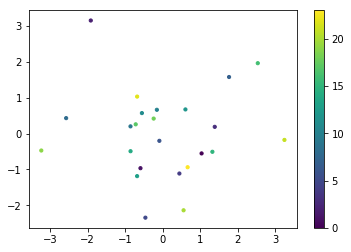

[[ 2.007002   -0.5444778   0.13813953  2.2049806 ]
 [ 0.13474026  1.6930089  -0.44278076 -0.3833948 ]
 [ 0.00522539  0.2952756  -1.4401698  -0.8471587 ]
 [-0.8392843  -1.0302026   1.9816213   0.6493134 ]
 [-0.26154727  0.3918539   0.40304488 -0.37173355]
 [ 0.5554839  -0.44442958 -1.3740333   2.0925484 ]
 [ 0.98985183 -0.05577741  0.07827802  0.48818392]]


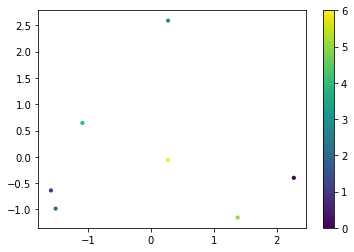

In [90]:
drawTSNE(range(24), range(24), gridModel.houremb)
drawTSNE(range(7), range(7), gridModel.weekemb)

[[ 0.914455   -0.5903582   1.1530627   0.30412522]
 [-0.33720794 -1.264809    1.414949    1.7721734 ]
 [-0.2968548  -1.4349606   1.253467    0.49732742]
 [ 1.6517937  -0.75685644  0.18583392 -0.93345165]
 [-0.17315787 -0.21904357 -0.06030564  0.43312943]
 [ 0.4363799  -0.19208407  0.28546104  0.04854025]
 [-0.69396067  0.33243418  1.3796642   0.01266043]
 [ 0.5632189  -0.6398172  -0.96168566 -0.31252143]
 [-0.7576503  -1.8796755  -0.09659315  0.9368106 ]
 [-0.22491632 -0.6720232   1.0299195   1.0965035 ]
 [-2.3463383  -0.7753797   0.0460392   0.75587505]
 [-0.48186862 -0.9461284   1.0251328  -0.16843994]
 [-0.7237842  -0.985791    0.09095516 -1.088165  ]
 [ 0.18080433 -0.49396813  0.32142368 -0.10139823]
 [ 0.5488926   0.6966787   0.16029985 -1.1921129 ]
 [-0.3346263  -0.35490668 -0.0282834  -0.18998827]
 [-1.1913027  -1.3730667   0.01163548 -1.9679252 ]
 [ 0.41258374 -0.8278788  -1.0981814  -1.1086373 ]
 [ 0.85091305 -0.65953207  0.43872738  0.13128309]
 [ 0.10708154 -0.32813478  1.81

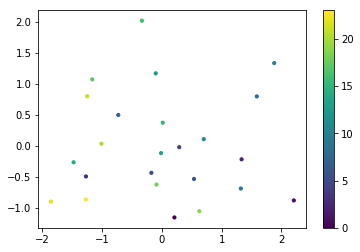

[[ 1.7576462e-01 -8.3499146e-01 -4.8558775e-01 -8.6679524e-01]
 [ 6.7074466e-01 -9.5658296e-01 -4.1928166e-01  1.9992038e+00]
 [-1.3715661e-03 -8.7452549e-01 -1.2417628e+00 -2.7125680e-01]
 [ 1.8180997e+00 -2.8713477e-01  6.0172373e-01 -1.6612873e+00]
 [ 7.9852432e-02  3.1464949e-01 -7.9826778e-01 -4.5102075e-01]
 [ 1.1994725e+00  3.8611752e-01  2.5162503e-01  3.0731814e+00]
 [ 1.3417856e+00  2.9944196e-01  9.3829495e-01  1.4390557e-01]]


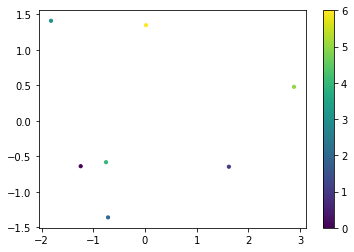

[[ 4.98099178e-01 -8.27342644e-02  7.78911188e-02 -1.23847961e+00
  -3.23539555e-01 -3.03213835e-01  4.31814164e-01  3.73259723e-01]
 [-1.54094100e-01 -4.99103755e-01 -8.05141151e-01 -1.48511577e+00
   4.61736083e-01  4.64351207e-01 -5.61365008e-01 -2.45635569e-01]
 [ 1.85655892e+00 -7.23395824e-01  1.33354199e+00 -9.83140051e-01
   5.02367914e-01  9.23127949e-01 -2.39101902e-01  1.56915915e+00]
 [-2.21975207e+00  2.00389600e+00 -8.92360687e-01 -4.34906036e-01
   7.01867878e-01 -3.20120335e-01 -9.83829856e-01 -5.09545624e-01]
 [-4.81808543e-01 -1.36400771e+00  6.13824844e-01  1.29532754e+00
   5.36526889e-02  3.03354263e-01  1.07620418e+00  4.54741299e-01]
 [-6.97803140e-01 -4.90285754e-01 -3.72919589e-01  9.49328125e-01
  -8.62066507e-01 -1.72324133e+00  9.17931378e-01  2.76088148e-01]
 [-1.38418829e+00  1.93493557e+00 -1.00864732e+00 -1.83287489e+00
   6.12823009e-01 -1.53099775e-01 -1.63114637e-01  6.17018342e-01]
 [-9.11386371e-01 -2.04190299e-01  8.71019483e-01 -1.76692462e+00
  -

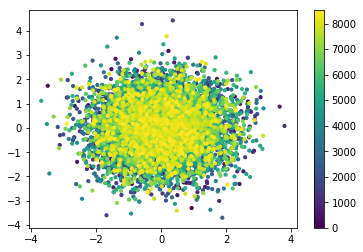

In [100]:
drawTSNE(range(24), range(24), cancelProbModel.houremb)
drawTSNE(range(7), range(7), cancelProbModel.weekemb)
drawTSNE(range(len(hex_grid_data['ID'])), range(len(hex_grid_data['ID'])), cancelProbModel.GIDemb)

In [115]:
class TestModel(nn.Module):
    def __init__(self, weekfeat = 4):
        super(TestModel, self).__init__()
        self.weekemb = nn.Embedding(7, weekfeat)
        self.fc = nn.Linear(4,1)
        
    def forward(self, week):
        week = self.weekemb(week)
        
        return self.fc(week)
testModel = cuda(TestModel())
opt = torch.optim.Adam(testModel.parameters(), 0.01)
loss = nn.MSELoss()

In [117]:
bs = 4096
for i in range(1000):
    a = np.random.randint(0,6,bs)
    b = a >= 4
    a = torch.tensor(a).cuda()
    b = torch.tensor(b).float().cuda()#.unsqueeze(1).repeat(1,4)
    testModel.train()
    opt.zero_grad()
    res = testModel(a).squeeze()
    l = loss(res, b)
    l.backward()
    opt.step()
    if i % 100 == 0:
        print(i, res)

0 tensor([ 0.0736,  0.0736,  0.3059,  ...,  0.3059,  0.8500, -0.0915],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
100 tensor([-1.6564e-03,  9.1937e-04,  5.6413e-04,  ..., -1.6564e-03,
         1.0002e+00,  1.0002e+00], device='cuda:0', grad_fn=<SqueezeBackward0>)
200 tensor([ 1.4156e-05,  1.4156e-05,  1.9848e-05,  ..., -2.3544e-06,
         9.9996e-01,  1.4156e-05], device='cuda:0', grad_fn=<SqueezeBackward0>)
300 tensor([ 8.9407e-08,  1.1921e-07,  2.0862e-07,  ..., -2.9802e-08,
         1.0000e+00,  2.0862e-07], device='cuda:0', grad_fn=<SqueezeBackward0>)
400 tensor([ 1.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -2.9802e-08,
         5.9605e-08,  0.0000e+00], device='cuda:0', grad_fn=<SqueezeBackward0>)
500 tensor([1.0000e+00, 0.0000e+00, 2.9802e-08,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0', grad_fn=<SqueezeBackward0>)
600 tensor([ 1.0000e+00, -2.9802e-08, -2.9802e-08,  ...,  0.0000e+00,
         2.9802e-08,  0.0000e+00], device='cuda:0', grad_fn=<Sq

In [21]:
np.random.randint(0,6,10)

array([0, 3, 1, 1, 2, 0, 1, 5, 3, 4])

In [53]:
best_result['model'] = best_result['opt'] = None
best_result

{'epoch': 999,
 'iteration': 50,
 'loss': 0.0034723819699138403,
 'model': None,
 'opt': None}

In [15]:
count = 0
for i in gridTrainDataLoader:
    print(count, i)
    count += 1
    if i[3].sum() + i[4].sum() > 0: break

0 [tensor([6972, 5522]), tensor([3, 1]), tensor([1, 4]), tensor([False, False]), tensor([-0.0953, -0.0953]), tensor([-0.2789, -0.2789])]
1 [tensor([7404, 5468]), tensor([ 8, 11]), tensor([3, 4]), tensor([False, False]), tensor([-0.0953,  0.6961]), tensor([-0.2789,  3.4602])]


In [16]:
count = 0
for i in range((grid_order_reward_all_data['GID'].reshape(-1).shape[0])):
    if grid_order_reward_all_data['reward'].reshape(-1)[i] != 0:
        #print(grid_order_reward_all_data['hour'][i], grid_order_reward_all_data['weekday'][i])
        count += 1
print(count)

1431192


In [17]:
grid_order_reward_all_data['reward']

array([-0.27888531, -0.27888531, -0.27888531, ..., -0.27888531,
       -0.27888531, -0.27888531])

In [18]:
for i in range(8519):
    for j in range(24):
        for k in range(7):
            if grid_order_reward_all_data['reward'][i][j][k] != 0:
                print(i,j,k)

IndexError: invalid index to scalar variable.

In [19]:
torch.cat((torch.zeros(10),torch.zeros(10),torch.zeros(10)), ).shape

torch.Size([30])

In [20]:
cancel_prob_all_data

{'ETA': array([ 8.68988024e-01,  1.47504310e+00,  1.59265635e-01,  9.54703646e-02,
        -9.45987432e-01, -6.72075760e-02,  1.33747527e-01,  1.94353034e-01,
         4.83026635e-01, -4.32435502e-01,  2.62932951e-01,  1.03444773e-01,
        -3.54286295e-01, -4.14891802e-01,  8.59010740e-02,  6.23376231e-01,
        -6.81237058e-01, -4.56358728e-01, -9.50772077e-01,  2.54958542e-01,
        -1.05603427e+00,  1.67280844e+00, -4.30840620e-01,  5.54796315e-01,
         5.08544743e-01, -1.10228585e+00, -8.48699644e-01,  8.24331334e-01,
        -3.27173305e-01, -6.87616585e-01, -1.19957363e+00,  8.03597871e-01,
        -3.68640231e-01,  8.96101014e-01,  1.00136321e+00, -1.29407965e-01,
         1.76809335e-01, -8.94951215e-01, -7.83309491e-01,  1.17798709e-01,
         1.62974663e+00, -8.88571688e-01,  6.80791975e-01, -8.82192161e-01,
         4.75052226e-01, -8.99735861e-01, -7.83309491e-01, -1.19838674e-01,
         1.70429808e-01,  2.61059892e+00,  5.75529778e-01, -1.10547561e+00,
     

In [21]:
grid_order_reward_all_data

{'GID': array([   0,    0,    0, ..., 8518, 8518, 8518]),
 'hour': array([ 0,  0,  0, ..., 23, 23, 23]),
 'order': array([-0.09529744, -0.09529744, -0.09529744, ..., -0.09529744,
        -0.09529744, -0.09529744]),
 'reward': array([-0.27888531, -0.27888531, -0.27888531, ..., -0.27888531,
        -0.27888531, -0.27888531]),
 'weekday': array([0, 1, 2, ..., 4, 5, 6])}

In [86]:
rr = pickle.load(open(pkl_folder + 'ride_req.pkl', 'rb'))

In [91]:
res = []
rrlen = len(rr['ID'])

In [93]:
rr.keys()

dict_keys(['pos', 'grid', 'ID', 'time', 'reward', 'end_grid', 'start_grid'])

In [115]:
from common import real_distance, min_gps, max_gps

In [116]:
res = []
for i in range(len(rr['ID'])):
    dis = ((np.abs(rr['pos'][i][0] - rr['pos'][i][1]) / (max_gps - min_gps) * real_distance) ** 2).sum() ** 0.5
    time = rr['time'][i][1] - rr['time'][i][0]
    res.append([dis, time])

In [120]:
rrr = [x[0] / x[1] for x in res if x[1] > 0]

In [124]:
np.mean(rrr)

5.705190955808098

In [44]:
gr = pickle.load(open(pkl_folder + 'grid_order_reward.pkl', 'rb'))
gr = gr['order']

In [54]:
(gr.sum(axis=1).sum(axis=1)==0).sum()

6052